<a href="https://colab.research.google.com/github/sahassawat-u/vision-transformer-with-covid19/blob/main/vit_with_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tawsifurrahman/covid19-radiography-database
! unzip covid19-radiography-database

In [ ]:
! mkdir dataset
! mkdir ./dataset/train
! mkdir ./dataset/test
! mkdir ./dataset/train/COVID
! mkdir ./dataset/train/Normal
! mkdir ./dataset/test/COVID
! mkdir ./dataset/test/Normal

In [ ]:
import glob
import shutil
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
from skimage import img_as_ubyte

kaggle_dir = './COVID-19_Radiography_Dataset'
covid_dir = kaggle_dir+'/COVID/'
normal_dir = kaggle_dir+'/Normal/'
data_dir = './dataset/'

covid_imgs = glob.glob(covid_dir+'images/*')
normal_imgs = glob.glob(normal_dir+'images/*')
# covid_masks = glob.glob(covid_dir+'masks/*')
# normal_masks = glob.glob(normal_dir+'masks/*')

cnt = 1
phase = 'train'
n = len(covid_imgs)

for file_name in zip(covid_imgs,normal_imgs):

  if cnt==int(n*0.75):phase='test'
  if cnt==n:break

  covid_img = cv2.imread(file_name[0])
  covid_img = cv2.resize(covid_img, (224,224))
  covid_img = covid_img/255
  covid_img = img_as_ubyte(covid_img) 

  normal_img = cv2.imread(file_name[1])
  normal_img = cv2.resize(normal_img, (224,224))
  normal_img = normal_img/255
  normal_img = img_as_ubyte(normal_img) 

  shutil.move(covid_img,data_dir+ phase + '/COVID/')
  shutil.move(normal_img,data_dir+ phase + '/Normal/')
  cnt += 1

In [ ]:
print('--------train---------')
print(f"size of COVID files: {len(glob.glob(data_dir+'train/COVID/*'))}")
print(f"size of Normal files: {len(glob.glob(data_dir+'train/Normal/*'))}")
print('--------test----------')
print(f"size of COVID files: {len(glob.glob(data_dir+'test/COVID/*'))}")
print(f"size of Normal files: {len(glob.glob(data_dir+'test/Normal/*'))}")

--------train---------
size of COVID files: 2711
size of Normal files: 2711
--------test----------
size of COVID files: 904
size of Normal files: 904


In [ ]:
! rm -r ./COVID-19_Radiography_Dataset/

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install einops

In [ ]:
from torch import Tensor
from PIL import Image
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.transforms import Compose,ToTensor,Resize
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_tfms = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(*stats,inplace=True)])

valid_tfms = transforms.Compose([transforms.ToTensor(),transforms.Resize(224), transforms.Normalize(*stats)])
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
batch_size = 16

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def training_step(model, batch):
    images, labels = batch 
    # Generate predictions
    out = model(images)                 
    # Calculate loss 
    loss = F.cross_entropy(out, labels) 
    return loss

def validation_step(model, batch):
    images, labels = batch 
    # Generate predictions
    out = model(images)                   
    # Calculate loss 
    loss = F.cross_entropy(out, labels)   
    # Calculate accuracy
    acc = accuracy(out, labels)           
    return {'val_loss': loss.detach(), 'val_acc': acc}
    
def validation_epoch_end(model, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    # Combine losses
    epoch_loss = torch.stack(batch_losses).mean()   
    batch_accs = [x['val_acc'] for x in outputs]
    # Combine accuracies
    epoch_acc = torch.stack(batch_accs).mean()      
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

- Data
- Patches Embeddings
    - CLS Token
    - Position Embedding
- Transformer
    - Attention
    - Residuals
    - MLP
    - TransformerEncoder
- Head
- ViT

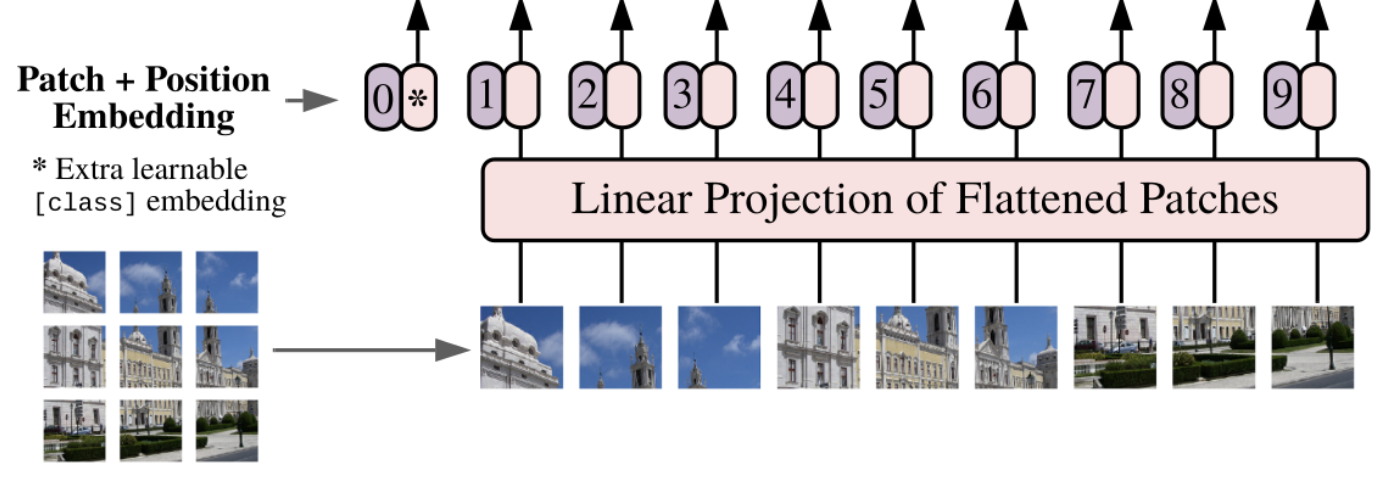

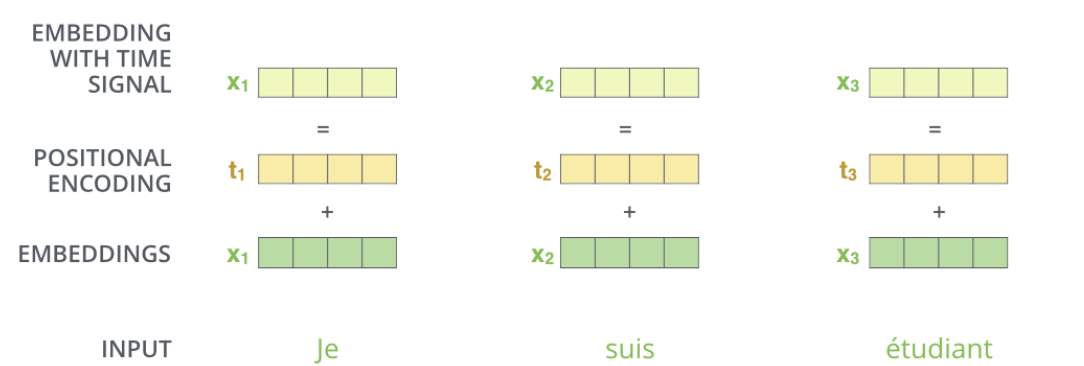

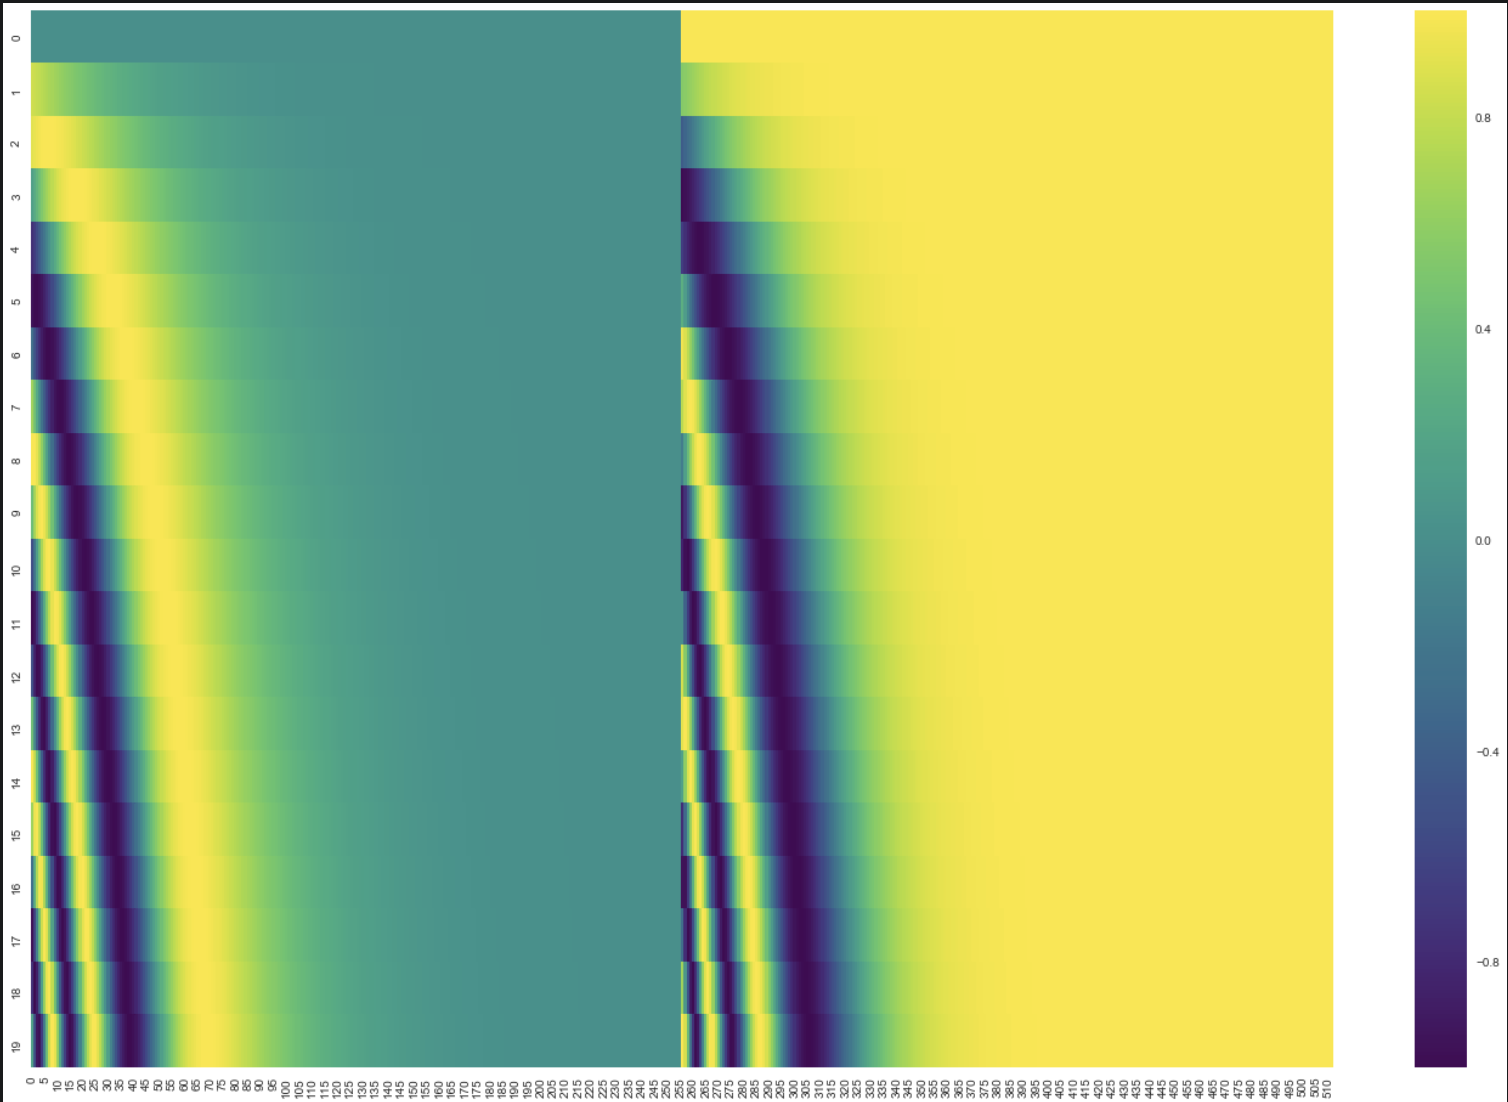

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            #Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            #nn.Linear(patch_size * patch_size * in_channels, emb_size)
             # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions

        return x

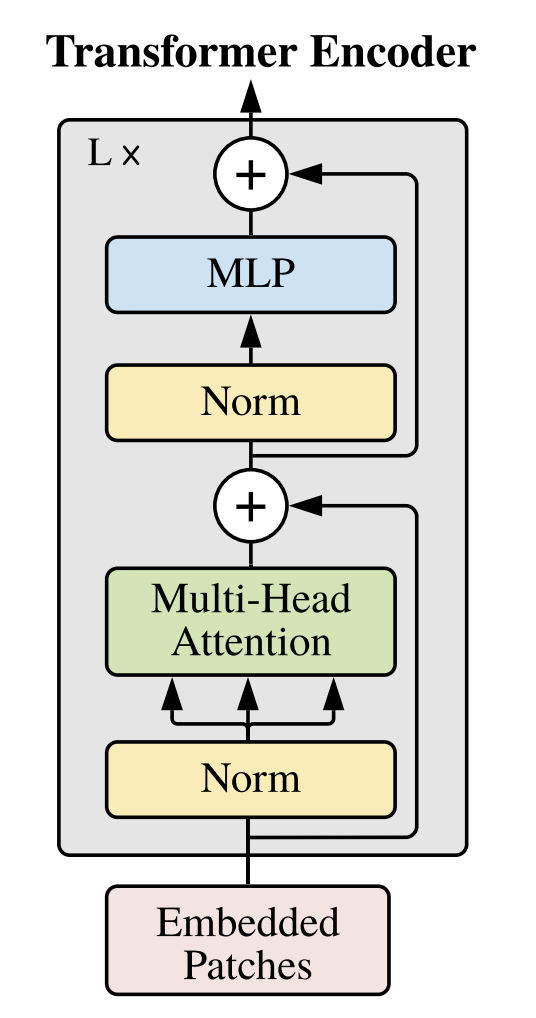

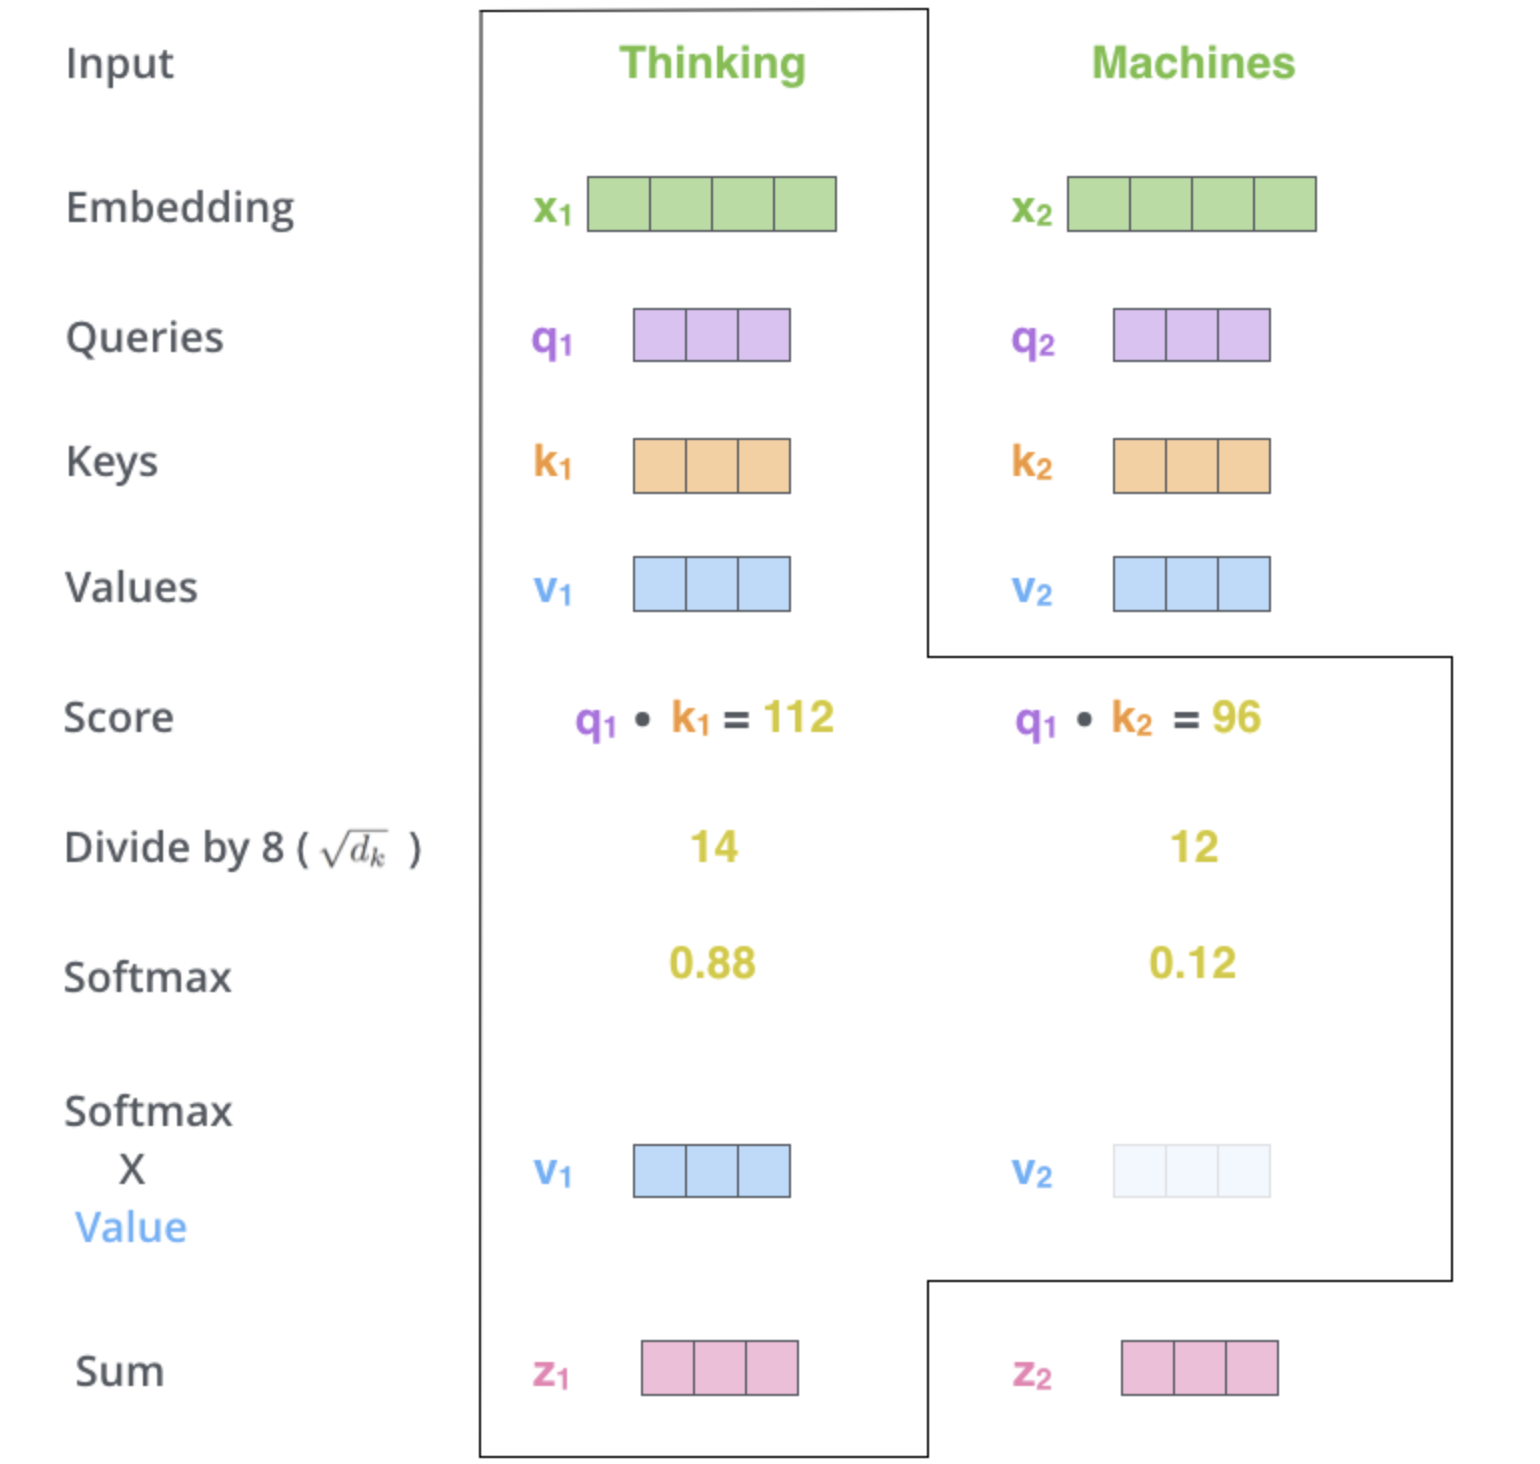

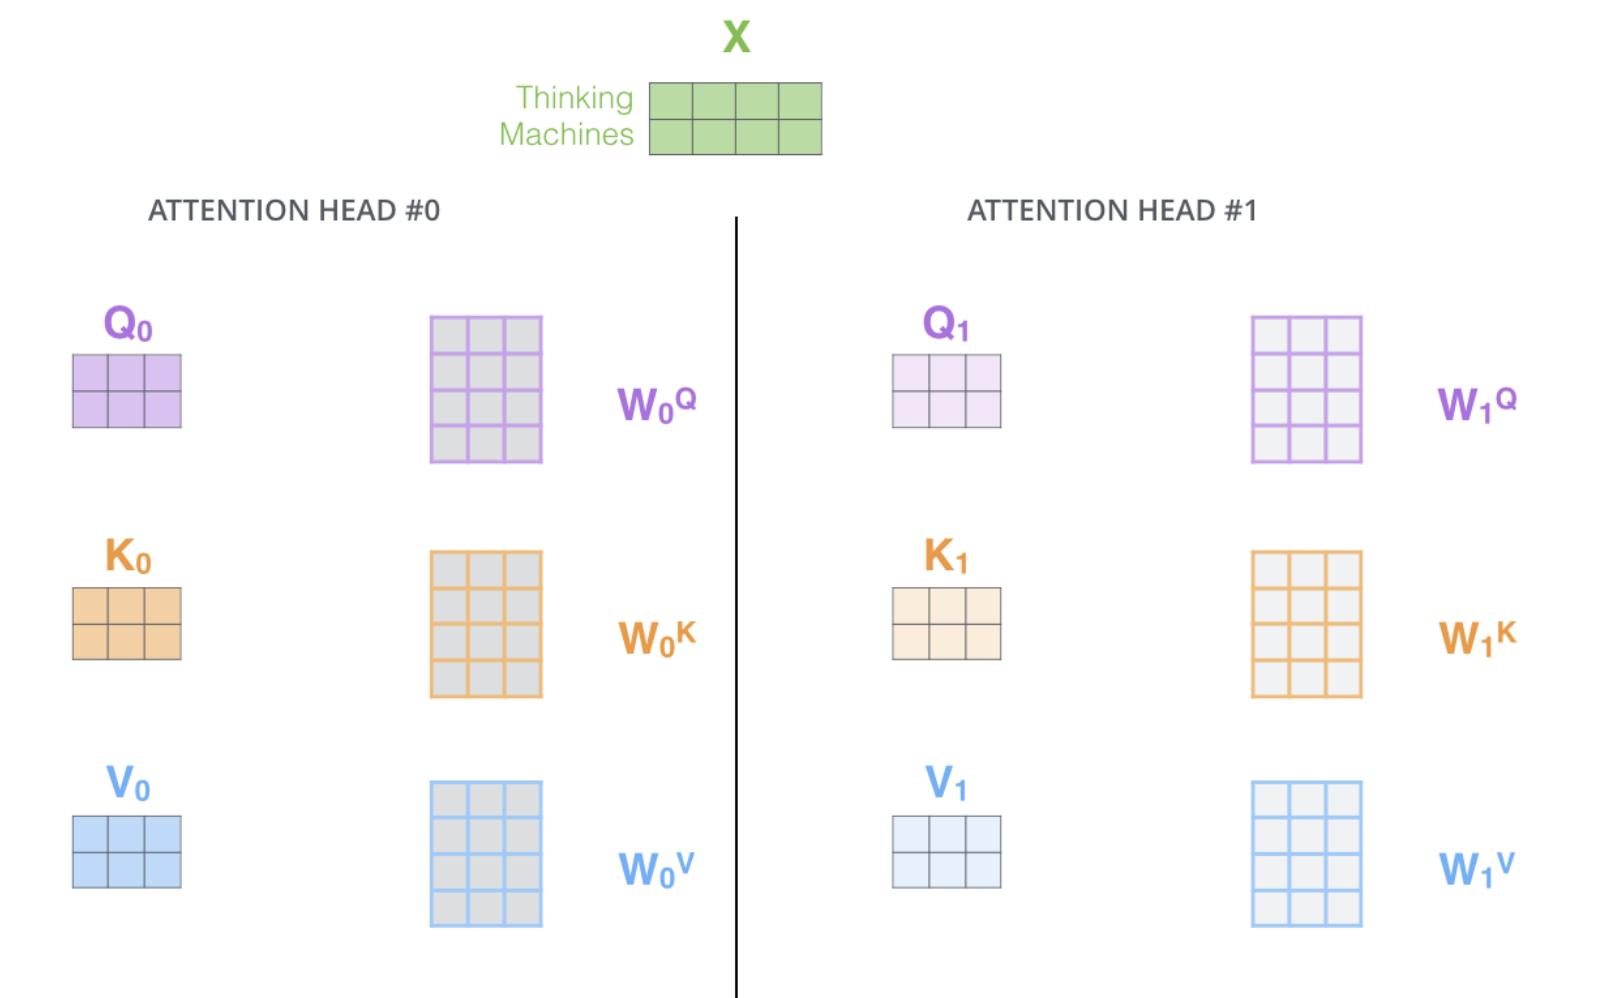

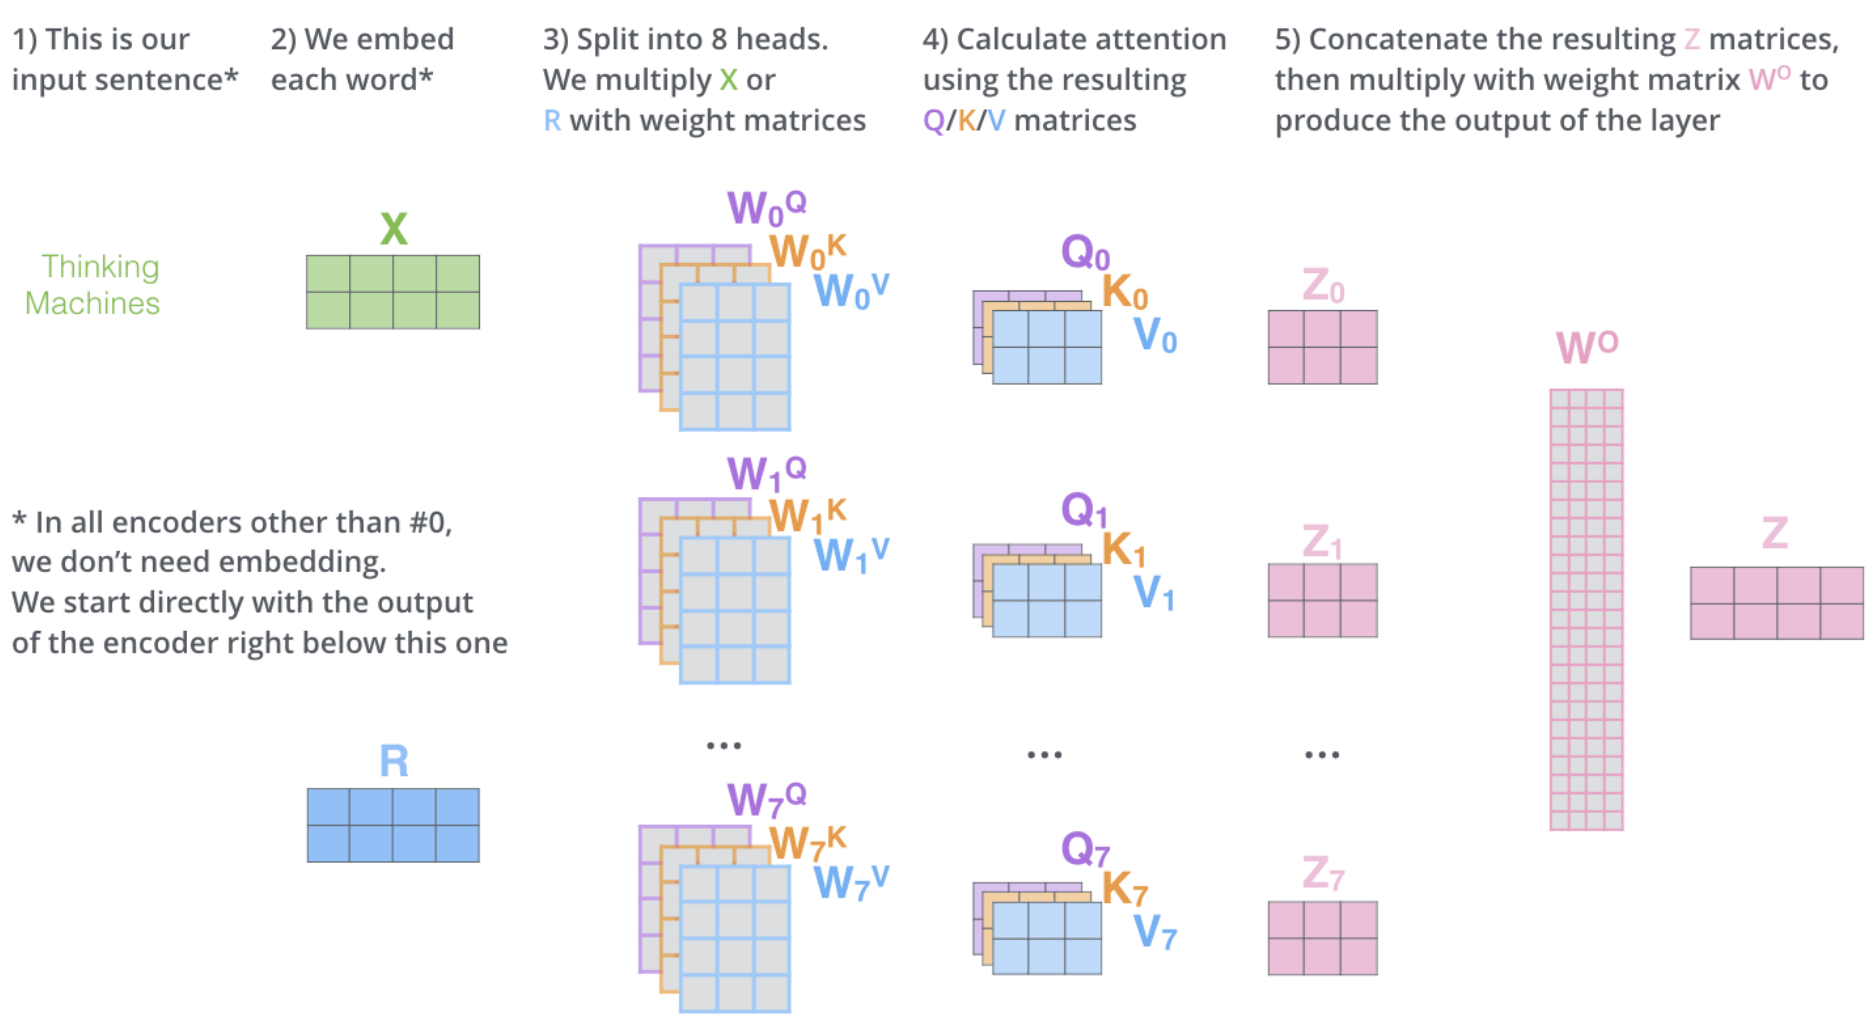

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

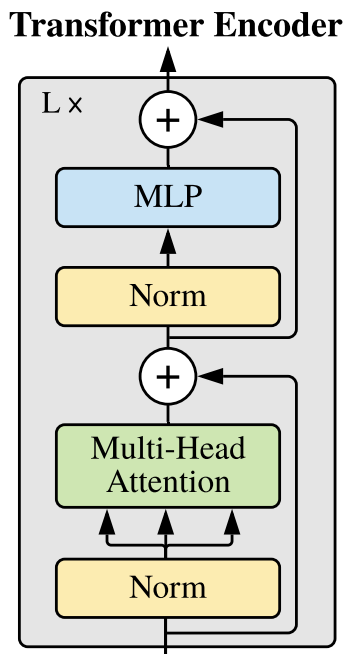

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

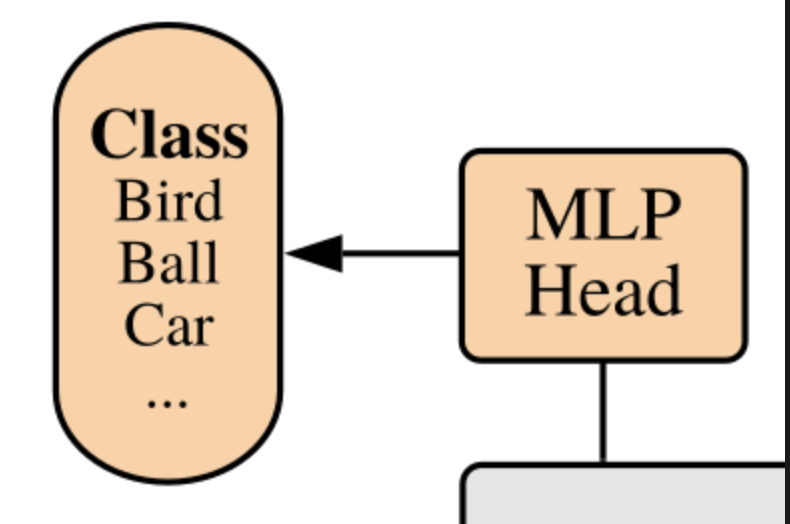

In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model,epoch, result)
        history.append(result)
    return history

In [ ]:
vit_16_model = to_device(ViT(in_channels=3,n_classes=2), device)

In [ ]:
vit_16_history = [evaluate(vit_16_model, train_dl)]
vit_16_history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.5000263452529907, 'val_loss': 0.7081358432769775}]

In [ ]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
vit_16_history += fit_one_cycle(epochs, max_lr, vit_16_model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
cpuset_checked))
Epoch [0], last_lr: 0.00081, train_loss: 0.7740, val_loss: 0.6597, val_acc: 0.5973
Epoch [1], last_lr: 0.00198, train_loss: 0.7150, val_loss: 0.6673, val_acc: 0.6217
Epoch [2], last_lr: 0.00371, train_loss: 0.7078, val_loss: 0.6657, val_acc: 0.6444
Epoch [3], last_lr: 0.00570, train_loss: 0.6766, val_loss: 0.6766, val_acc: 0.6665
Epoch [4], last_lr: 0.00760, train_loss: 0.6405, val_loss: 0.6174, val_acc: 0.6792
Epoch [5], last_lr: 0.00908, train_loss: 0.6232, val_loss: 0.6025, val_acc: 0.6698
Epoch [6], last_lr: 0.00990, train_loss: 0.6245,

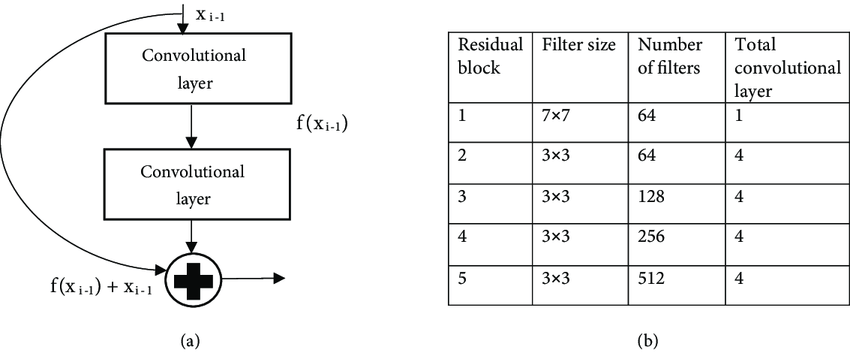

In [ ]:
from torchvision.models import resnet18
resnet18_model = resnet18()

In [ ]:
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, 2)
resnet18_model = to_device(resnet18_model, device)

In [ ]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
resnet18_history = [evaluate(resnet18_model, train_dl)]
resnet18_history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.49992096424102783, 'val_loss': 0.7227814793586731}]

In [ ]:
%%time
resnet18_history += fit_one_cycle(epochs, max_lr, resnet18_model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00081, train_loss: 0.3878, val_loss: 0.4622, val_acc: 0.7765
Epoch [1], last_lr: 0.00198, train_loss: 0.3161, val_loss: 0.5808, val_acc: 0.7284
Epoch [2], last_lr: 0.00371, train_loss: 0.3031, val_loss: 0.5611, val_acc: 0.7832
Epoch [3], last_lr: 0.00570, train_loss: 0.3148, val_loss: 0.3953, val_acc: 0.8523
Epoch [4], last_lr: 0.00760, train_loss: 0.2978, val_loss: 1.7998, val_acc: 0.5105
Epoch [5], last_lr: 0.00908, train_loss: 0.3161, val_loss: 0.3121, val_acc: 0.8656
Epoch [6], last_lr: 0.00990, train_loss: 0.2917, val_loss: 0.4090, val_acc: 0.8789
Epoch [7], last_lr: 0.00998, train_loss: 0.2747, val_loss: 0.3890, val_acc: 0.8529
Epoch [8], last_lr: 0.00982, train_loss: 0.2814, val_loss: 0.2450, val_acc: 0.9110
Epoch [9], last_lr: 0.00950, train_loss: 0.2572, val_loss: 0.2061, val_acc: 0.9237
Epoch [10], last_lr: 0.00905, train_loss: 0.2659, val_loss: 0.3028, val_acc: 0.8838
Epoch [11], last_lr: 0.00846, train_loss: 0.2331, val_loss: 0.3194, val_acc: 0.8750
Ep

## Time used in training

Training time for ResNet18 is 23 minutes 16 seconds 

Training time for ViT-B/16 is 3 hours 2 minutes 

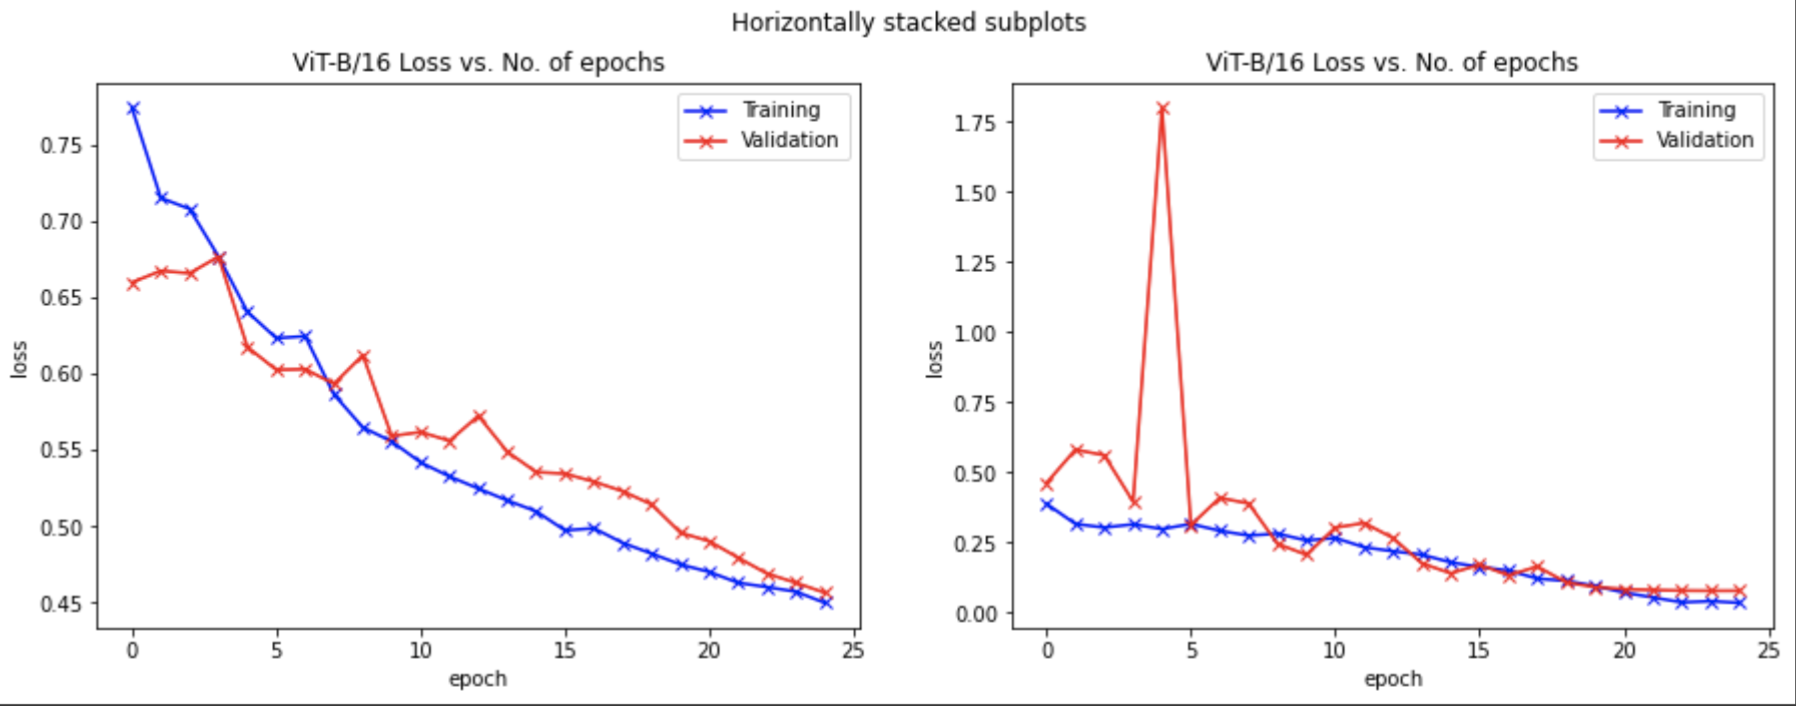

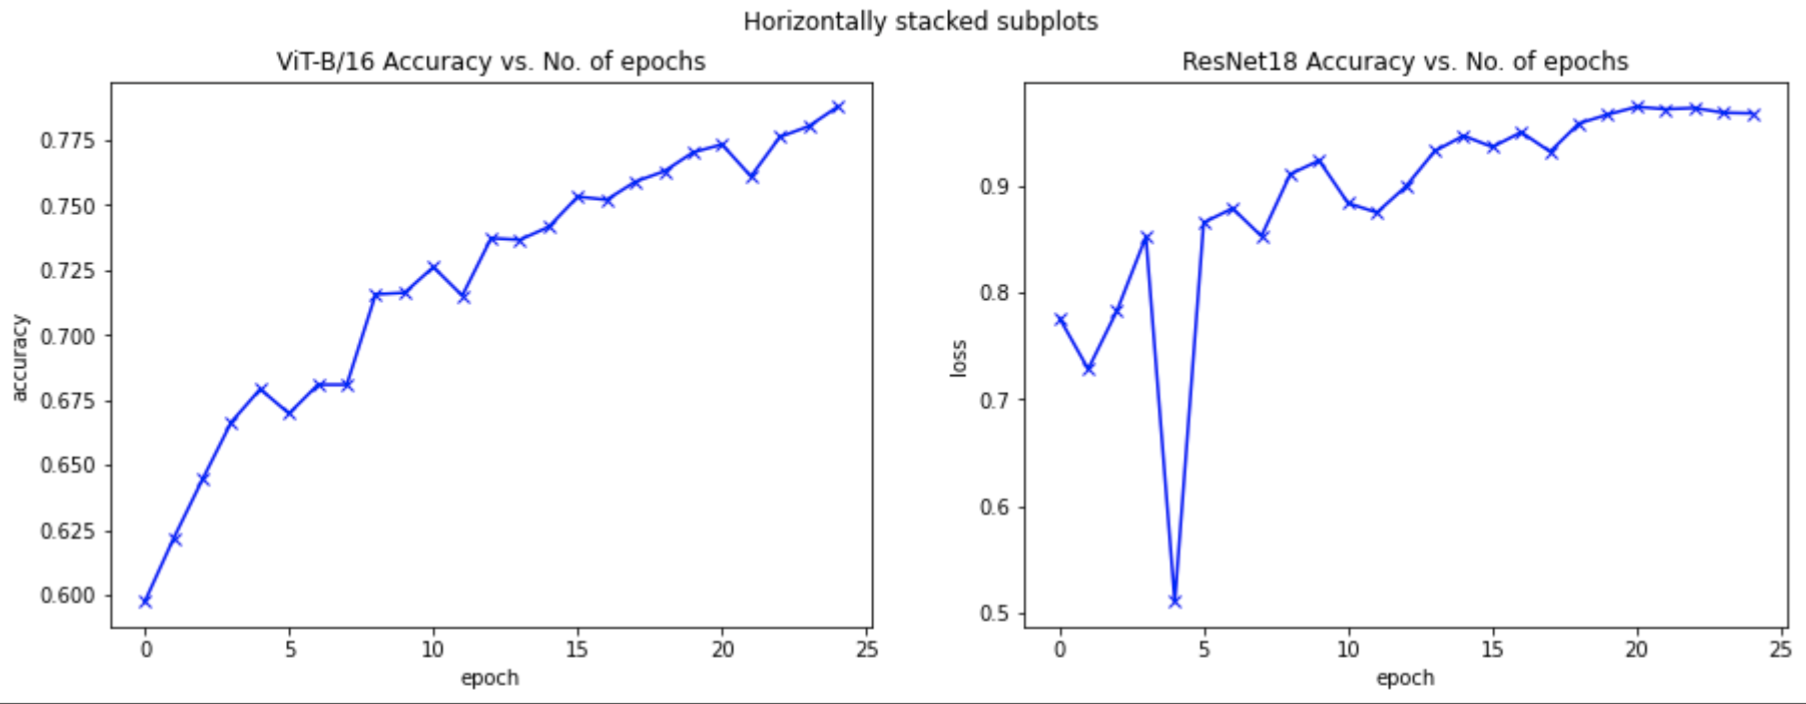

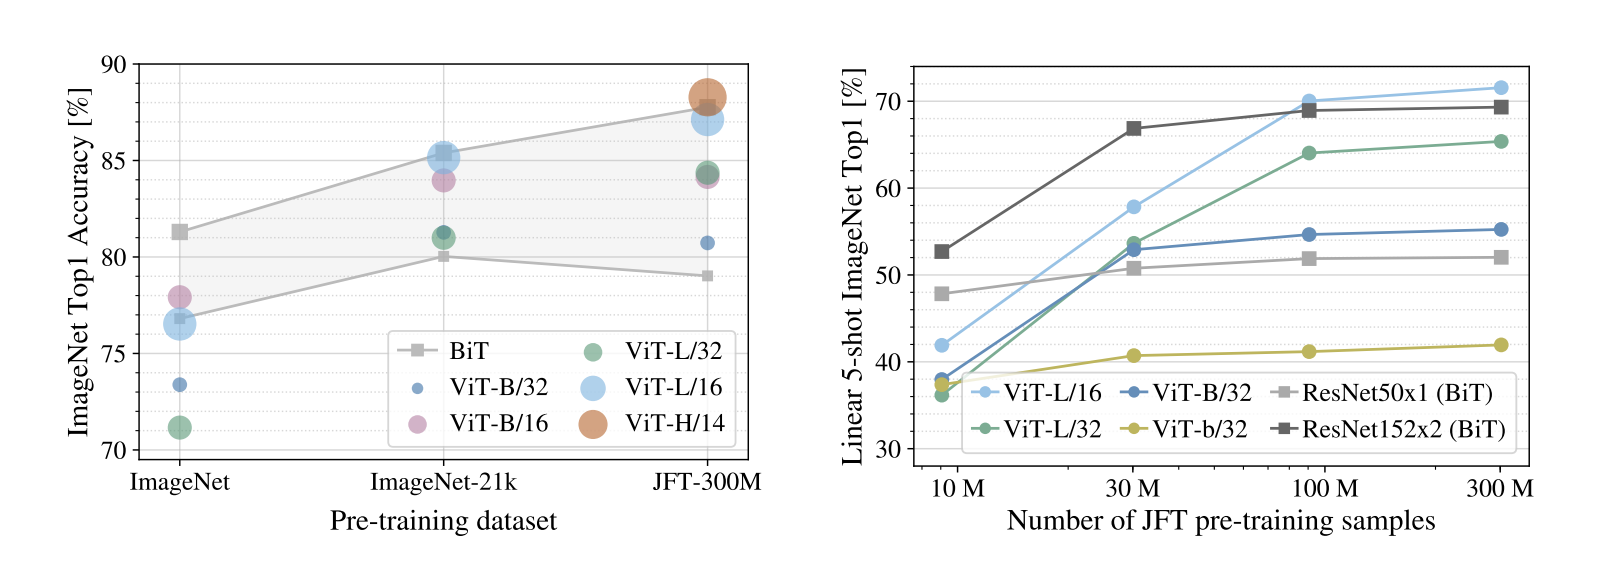

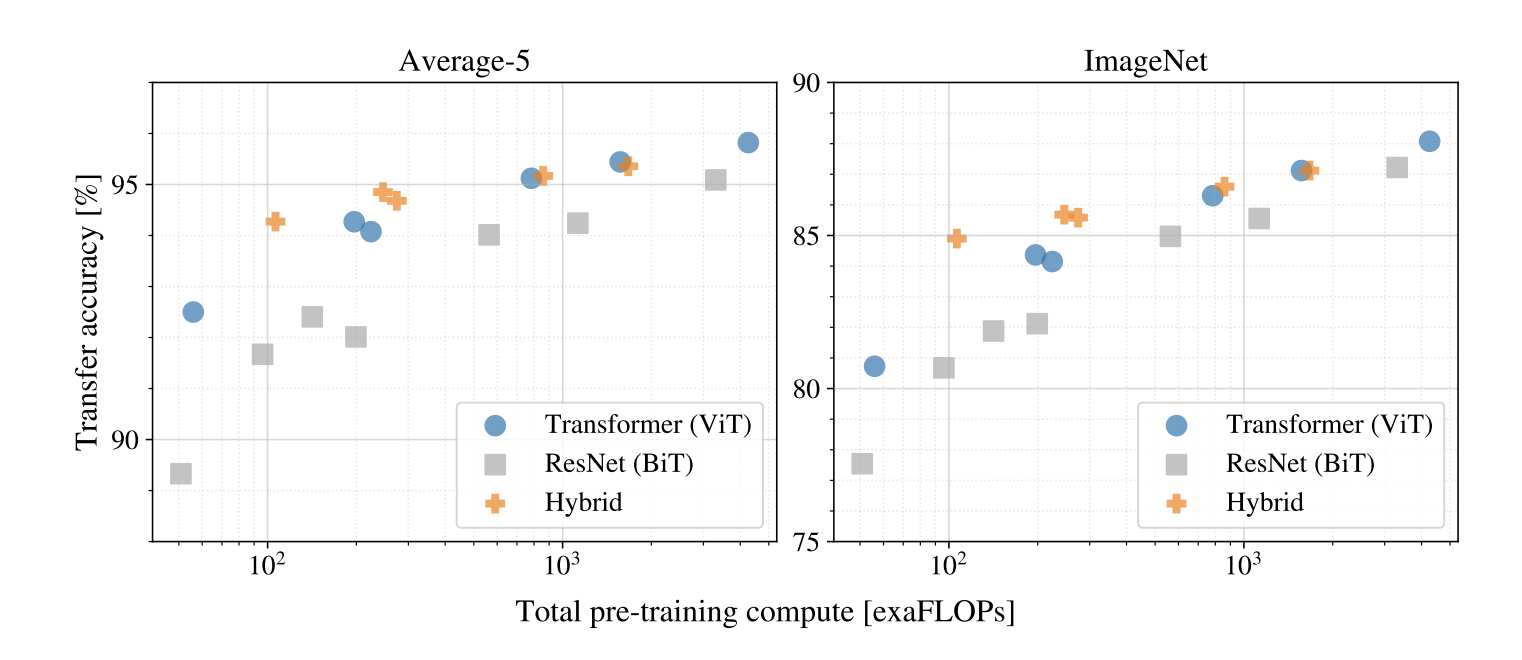